In [1]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pylab as pylab
import upsetplot
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz8-1/avaraby/orfanage/soft")
%aimport definitions

In [3]:
# paths

base_dir = "/ccb/salz8-1/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"
td_bin = base_dir+"soft/transdecoder/TransDecoder.LongOrfs"
tdp_bin = base_dir+"soft/transdecoder/TransDecoder.Predict"
gtf_genome_to_cdna_fasta = base_dir+"soft/transdecoder/util/gtf_genome_to_cdna_fasta.pl"
gtf_to_alignment_gff3 = base_dir+"soft/transdecoder/util/gtf_to_alignment_gff3.pl"
cdna_alignment_orf_to_genome_orf = base_dir+"soft/transdecoder/util/cdna_alignment_orf_to_genome_orf.pl"

fa_fname = base_dir+"data/hg38.fa"
gtf_fname = base_dir+"data/gencode.v41.gtf"
mane_gtf_fname = base_dir+"data/MANE.v10.gtf"

td_outdir = base_dir+"td_gencode/"
if not os.path.exists(td_outdir):
    os.makedirs(td_outdir)

In [4]:
# arguments
num_threads = 30

In [5]:
gtf_adjstop_fname = gtf_fname.rsplit(".",1)[0]+".adjstop.gtf"
gtf_adjstop_sorted_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".sorted.gtf"
gtf_adjstop_aa_fa_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".aa.fa"

clean_gtf_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".clean.gtf"
nocds_gtf_fname = clean_gtf_fname.rsplit(".",1)[0]+".nocds.gtf"
nocds_gff_fname = nocds_gtf_fname.rsplit(".",1)[0]+".gff3"
nocds_fa_fname = nocds_gtf_fname.rsplit(".",1)[0]+".fa"

out_gtf_fname = td_outdir+"orf.gtf"
out_stats_fname = td_outdir+"orf.stats"
out_gtf_sorted_fname = td_outdir.rsplit(".",1)[0]+".sorted.gtf"

out_df_tsv_fname = td_outdir+"df.tsv"

In [9]:
%%time
# run orfanage with mane as the reference
cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",nocds_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtf_fname,
       "--stats",out_stats_fname,
       mane_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.clean.nocds.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/td_gencode/orf.gtf --stats /ccb/salz8-1/avaraby/orfanage/td_gencode/orf.stats /ccb/salz8-1/avaraby/orfanage/data/MANE.v10.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


CPU times: user 4.96 ms, sys: 9.89 ms, total: 14.9 ms
Wall time: 21.7 s


0

In [8]:
%%time
# construct the transcript fasta file using the genome and the transcripts.gtf file like so:

cvt_cmd = [gtf_genome_to_cdna_fasta,nocds_gtf_fname,fa_fname]

outFP = open(nocds_fa_fname,"w")
subprocess.call(cvt_cmd,stdout=outFP)
outFP.close()

# Next, convert the transcript structure GTF file to an alignment-GFF3 formatted file (this is done only because our processes operate on gff3 rather than the starting gtf file - nothing of great consequence). Convert gtf to alignment-gff3 like so, using cufflinks GTF output as an example:

gff_cmd = [gtf_to_alignment_gff3,nocds_gtf_fname]

outFP = open(nocds_gff_fname,"w")
subprocess.call(gff_cmd,stdout=outFP)
outFP.close()

# Now, run the process described above to generate your best candidate ORF predictions:

td_cmd = [td_bin,
          "-t",nocds_fa_fname]
subprocess.call(td_cmd)

# (optionally, identify peptides with homology to known proteins)
tdp_cmd = [tdp_bin,
           "-t",nocds_fa_fname]
subprocess.call(tdp_cmd)

# And finally, generate a genome-based coding region annotation file:

otg_cmd = [cdna_alignment_orf_to_genome_orf,
           "/ccb/salz8-1/avaraby/orfanage/notebooks/gencode.v41.adjstop.clean.nocds.fa.transdecoder.gff3",
           nocds_gff_fname,
           nocds_fa_fname]

outFP = open(td_outdir+"td.genome.gff3","w")
subprocess.call(otg_cmd,stdout=outFP)
outFP.close()

# convert to gtf
td_gtf_fname = td_outdir+"td.genome.gtf"
cmd = ["gffread","-T","-o",td_gtf_fname,td_outdir+"td.genome.gff3"]
subprocess.call(cmd)

-parsing cufflinks output: /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.clean.nocds.gtf
-parsing genome fasta: /ccb/salz8-1/avaraby/orfanage/data/hg38.fa
-done parsing genome.
// processing chr1
// processing chr10
// processing chr11
// processing chr12
// processing chr13
// processing chr14
// processing chr15
// processing chr16
// processing chr17
// processing chr18
// processing chr19
// processing chr2
// processing chr20
// processing chr21
// processing chr22
// processing chr3
// processing chr4
// processing chr5
// processing chr6
// processing chr7
// processing chr8
// processing chr9
// processing chrM
// processing chrX
// processing chrY
* [Mon Mar 13 22:22:01 2023] Running CMD: /ccb/salz8-1/avaraby/orfanage/soft/transdecoder/util/compute_base_probs.pl /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.clean.nocds.fa 0 > /ccb/salz8-1/avaraby/orfanage/notebooks/gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/base_freqs.dat


-first extracting base fre

CMD: touch /ccb/salz8-1/avaraby/orfanage/notebooks/gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/__checkpoints_longorfs/TD.longorfs.ok




#################################
### Done preparing long ORFs.  ###
##################################

	Use file: /ccb/salz8-1/avaraby/orfanage/notebooks/gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/longest_orfs.pep  for Pfam and/or BlastP searches to enable homology-based coding region identification.

	Then, run TransDecoder.Predict for your final coding region predictions.


* [Mon Mar 13 22:32:02 2023] Running CMD: /ccb/salz8-1/avaraby/orfanage/soft/transdecoder/util/get_top_longest_fasta_entries.pl gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/longest_orfs.cds 5000 5000 > gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/longest_orfs.cds.top_longest_5000
* [Mon Mar 13 22:32:17 2023] Running CMD: /ccb/salz8-1/avaraby/orfanage/soft/transdecoder/util/exclude_similar_proteins.pl gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/longest_orfs.cds.top_longest_5000 > gencode.v41.adjstop.clean.nocds.fa.transdecoder_dir/longest_orfs.cds.top_longest_5000.nr
-skipping tra

CPU times: user 2.36 s, sys: 707 ms, total: 3.07 s
Wall time: 41min 5s


0

In [10]:
# use gffread -J to identify cases which have missing start/stop codons
td_clean_gtf_fname = td_outdir+"td.clean.genome.gtf"
j_cmd = ["gffread","-J","-T","-g",fa_fname,"-o",td_clean_gtf_fname,td_gtf_fname]
subprocess.call(j_cmd)

0

99062
83949
total number of transcripts: 72909
all equal: 45396
ORFanage==GENCODE!=TransDecoder: 18540
Of those, these many are coding in both GENCODE and ORFanage: 18540
Of those, these many are non-coding in both GENCODE and ORFanage: 0
ORFanage!=GENCODE==TransDecoder: 1298
Of those, these many are coding in both GENCODE and TransDecoder: 1298
Of those, these many are non-coding in both GENCODE and TransDecoder: 0
All different: 1629


/ccb/salz8-3/avaraby1/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ilpd_diff'>

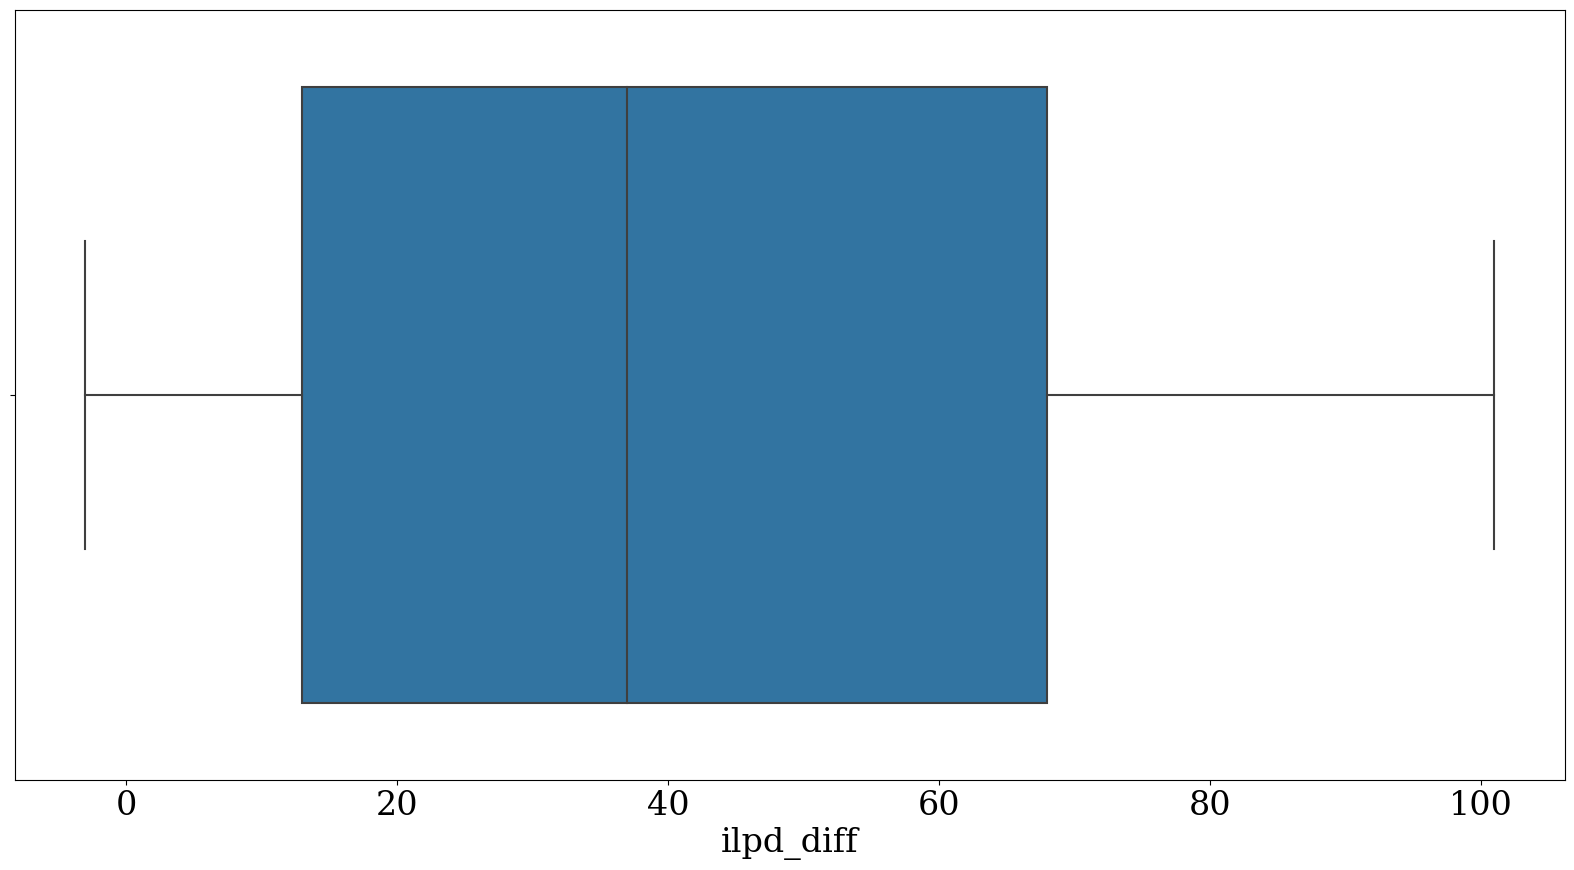

In [11]:
# load chains
td_df = definitions.get_chains(td_clean_gtf_fname,"CDS",True)
# clean extra tags from tid
td_df.rename({"tid":"td_tid"},axis=1,inplace=True)
td_df["tid"] = td_df["td_tid"].str.rsplit(".",n=1,expand=True)[0]
# extract length from the chain
td_df["clen"] = td_df.apply(lambda row: definitions.clen(row["chain"]),axis=1)
# sort and remove duplicates keeping only the longest ORF
td_df.sort_values(by=["tid","clen"],ascending=False,inplace=True)
print(len(td_df))
td_df.drop_duplicates(["tid"],keep="first",inplace=True)
td_df.drop("td_tid",axis=1,inplace=True)
print(len(td_df))

# remove junk and rename
td_df = td_df[["tid","has_cds","chain"]]
td_df.columns = ["tid","td_has_cds","td_chain"]


# load original chains
def_df = definitions.get_chains(clean_gtf_fname,"CDS",True)
# add gene ids
def_attr = definitions.get_attribute(clean_gtf_fname,"gene_id")
def_attr.columns = ["tid","gid"]
def_df = def_df.merge(def_attr,on="tid",how="left")
def_df = def_df[["tid","gid","has_cds","chain"]]
def_df.columns = ["tid","gid","def_has_cds","def_chain"]


# load orfanage results
orf_df = definitions.get_chains(out_gtf_fname,"CDS",True)
orf_df = orf_df[["tid","has_cds","chain"]]
orf_df.columns = ["tid","orf_has_cds","orf_chain"]


# load mane
mane_df = definitions.get_chains(mane_gtf_fname,"CDS",True)
# add gene ids
mane_attr = definitions.get_attribute(mane_gtf_fname,"gene_id")
mane_attr.columns = ["tid","gid"]
mane_df = mane_df.merge(def_attr,on="tid",how="left")
mane_df = mane_df[["tid","gid","chain","strand","coords"]]
mane_df.columns = ["mane_tid","gid","mane_chain","strand","coords"]


# merge all dataframes into one
df = def_df.merge(mane_df,on="gid",how="left")
df = df[df["gid"].isin(set(mane_df["gid"]))].reset_index(drop=True)
df = df.merge(td_df,on="tid",how="left")
df = df.merge(orf_df,on="tid",how="left")
df["td_has_cds"] = df["td_has_cds"].fillna(0)
df["td_chain"] = df.apply(lambda row: list() if row["td_chain"]!=row["td_chain"] else row["td_chain"],axis=1)

df = df[df["def_has_cds"]==1].reset_index(drop=True)

all_same = df[(df["td_chain"]==df["orf_chain"])&\
              (df["orf_chain"]==df["def_chain"])].reset_index(drop=True)

orf_eq_def_ne_td = df[~(df["td_chain"]==df["orf_chain"])&\
                       (df["orf_chain"]==df["def_chain"])].reset_index(drop=True)

td_eq_def_ne_orf = df[~(df["td_chain"]==df["orf_chain"])&\
                       (df["td_chain"]==df["def_chain"])].reset_index(drop=True)

ad = df[~(df["td_chain"]==df["orf_chain"])&\
              ~(df["td_chain"]==df["def_chain"])&\
              ~(df["orf_chain"]==df["def_chain"])].reset_index(drop=True)

print("total number of transcripts: "+str(len(df)))
print("all equal: "+str(len(all_same)))
print("ORFanage==GENCODE!=TransDecoder: "+str(len(orf_eq_def_ne_td)))
print("Of those, these many are coding in both GENCODE and ORFanage: "+str(len(orf_eq_def_ne_td[orf_eq_def_ne_td["orf_has_cds"]==1])))
print("Of those, these many are non-coding in both GENCODE and ORFanage: "+str(len(orf_eq_def_ne_td[orf_eq_def_ne_td["orf_has_cds"]==0])))
print("ORFanage!=GENCODE==TransDecoder: "+str(len(td_eq_def_ne_orf)))
print("Of those, these many are coding in both GENCODE and TransDecoder: "+str(len(td_eq_def_ne_orf[td_eq_def_ne_orf["td_has_cds"]==1])))
print("Of those, these many are non-coding in both GENCODE and TransDecoder: "+str(len(td_eq_def_ne_orf[td_eq_def_ne_orf["td_has_cds"]==0])))

print("All different: "+str(len(ad)))

# compare mane ILPD
ad[["mod_chain_orf",
         "c1len_orf",
         "c2len_orf",
         "match_start_orf",
         "match_end_orf",
         "num_bp_extra_orf",
         "num_bp_missing_orf",
         "num_bp_inframe_orf",
         "num_bp_match_orf",
         "num_bp_outframe_orf",
         "lpd_orf",
         "ilpd_orf",
         "mlpd_orf"]] = ad.apply(lambda row: definitions.compare_and_extract(row["orf_chain"],row["mane_chain"],row["strand"]),axis=1)
ad.drop(["mod_chain_orf",
         "c1len_orf",
         "c2len_orf",
         "match_start_orf",
         "match_end_orf",
         "num_bp_extra_orf",
         "num_bp_missing_orf",
         "num_bp_inframe_orf",
         "num_bp_match_orf",
         "num_bp_outframe_orf",
         "lpd_orf",
         "mlpd_orf"],axis=1,inplace=True)

ad[["mod_chain_td",
         "c1len_td",
         "c2len_td",
         "match_start_td",
         "match_end_td",
         "num_bp_extra_td",
         "num_bp_missing_td",
         "num_bp_inframe_td",
         "num_bp_match_td",
         "num_bp_outframe_td",
         "lpd_td",
         "ilpd_td",
         "mlpd_td"]] = ad.apply(lambda row: definitions.compare_and_extract(row["td_chain"],row["mane_chain"],row["strand"]),axis=1)
ad.drop(["mod_chain_td",
         "c1len_td",
         "c2len_td",
         "match_start_td",
         "match_end_td",
         "num_bp_extra_td",
         "num_bp_missing_td",
         "num_bp_inframe_td",
         "num_bp_match_td",
         "num_bp_outframe_td",
         "lpd_td",
         "mlpd_td"],axis=1,inplace=True)

ad["ilpd_diff"] = ad["ilpd_orf"]-ad["ilpd_td"]
sns.boxplot(ad["ilpd_diff"])

In [12]:
orf_tp_df = (df[(df["def_has_cds"]==1)&(df["orf_chain"]==df["def_chain"])])
orf_fp_df = (df[(df["def_has_cds"]==0)&(df["orf_has_cds"]==1)])
orf_tn_df = (df[(df["def_has_cds"]==0)&(df["orf_chain"]==df["def_chain"])])
orf_fn_df = (df[(df["def_has_cds"]==1)&(df["orf_has_cds"]==0)])

print(len(orf_tp_df),len(orf_fp_df),len(orf_tn_df),len(orf_fn_df))
sens = len(orf_tp_df)/(len(orf_tp_df)+len(orf_fn_df))
print("perc_correct: "+str(len(orf_tp_df)/len(df)))
# spec = len(orf_tn_df)/(len(orf_tn_df)+len(orf_fp_df))
print(sens)

td_tp_df = (df[(df["def_has_cds"]==1)&(df["td_chain"]==df["def_chain"])])
td_fp_df = (df[(df["def_has_cds"]==0)&(df["td_has_cds"]==1)])
td_tn_df = (df[(df["def_has_cds"]==0)&(df["td_chain"]==df["def_chain"])])
td_fn_df = (df[(df["def_has_cds"]==1)&(df["td_has_cds"]==0)])

print(len(td_tp_df),len(td_fp_df),len(td_tn_df),len(td_fn_df))
sens = len(td_tp_df)/(len(td_tp_df)+len(td_fn_df))
print("perc_correct: "+str(len(td_tp_df)/len(df)))
# spec = len(td_tn_df)/(len(td_tn_df)+len(td_fp_df))
print(sens)

63936 0 0 246
perc_correct: 0.8769287742254043
0.9961671496681312
46694 0 0 16484
perc_correct: 0.6404421950650812
0.7390863908322517


In [13]:
sad = ad[(ad["td_has_cds"]==1)&(ad["orf_has_cds"]==1)].reset_index(drop=True)
print(len(sad[sad["ilpd_diff"]>0])/len(sad))
print(len(sad[sad["ilpd_diff"]==0])/len(sad))

0.5463917525773195
0.45017182130584193


/ccb/salz8-3/avaraby1/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ilpd_diff'>

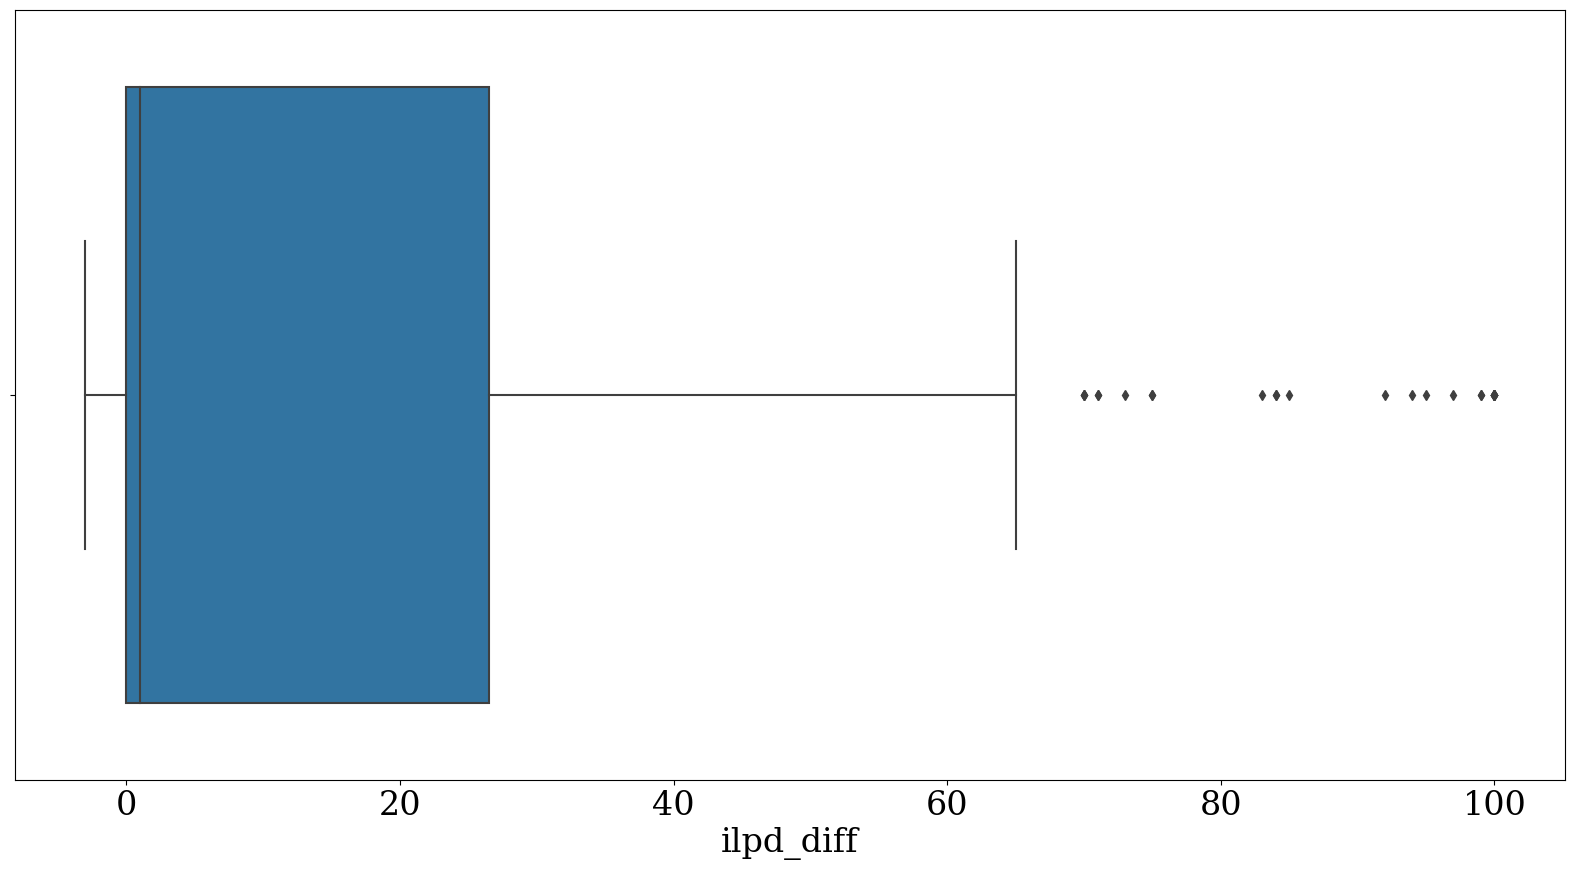

In [14]:
sns.boxplot(sad["ilpd_diff"])